In [2]:
import random
import numpy as np
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
from transformers import T5EncoderModel, T5Tokenizer
import torch

In [ ]:
import random
import numpy as np
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
from transformers import T5EncoderModel, T5Tokenizer
import torch

### 1. 读取 DGR 数据（VR/TR）
def read_dgr_fasta(file):
    sequences = {}
    for record in SeqIO.parse(file, "fasta"):
        parts = record.id.split("|")
        pair_id = "|".join(parts[:2])  # 提取 VR-TR 共享 ID
        tag = parts[-1]  # TR 或 VR
        
        if pair_id not in sequences:
            sequences[pair_id] = {"TR": None, "VR": None}
        
        sequences[pair_id][tag] = str(record.seq)
    
    return sequences

### 2. 读取 RT 数据（抽取部分数据用于测试）
def read_fasta(file, sample_size=5000):
    sequences = []
    for record in SeqIO.parse(file, "fasta"):
        sequences.append((record.id, str(record.seq)))
    return dict(random.sample(sequences, min(sample_size, len(sequences))))

### 3. 处理 VR-TR 片段并拼接
def preprocess_vr_tr(dgr_data):
    paired_data = []
    for pair_id, regions in dgr_data.items():
        if regions["VR"] and regions["TR"]:
            paired_data.append(regions["VR"] + "NNNNN" + regions["TR"])
    return paired_data

### 4. 计算 RT embedding（使用 GPU 加速）
def get_rt_embeddings(rt_fasta, sample_size=5000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("cuda is ready!")

    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50").to(device)
    print("model is ready!")
    
    rt_seqs = read_fasta(rt_fasta, sample_size)
    embeddings = {}
    for key, seq in rt_seqs.items():
        inputs = tokenizer(" ".join(seq), return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings[key] = outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()

    return embeddings

### 5. 分配 RT 特征给 VR-TR 片段
def assign_rt_to_vr_tr(vr_tr_list, rt_embeddings):
    rt_matrix = np.array(list(rt_embeddings.values()))
    avg_rt_feature = rt_matrix.mean(axis=0)  # 取全局均值
    return [np.concatenate([np.array(list(seq.encode())), avg_rt_feature]) for seq in vr_tr_list]

### 6. 生成最终训练数据
def generate_training_data(dgr_fasta, rt_fasta, sample_size=5000):
    dgr_data = read_dgr_fasta(dgr_fasta)
    vr_tr_pairs = preprocess_vr_tr(dgr_data)
    
    rt_embeddings = get_rt_embeddings(rt_fasta, sample_size)
    processed_data = assign_rt_to_vr_tr(vr_tr_pairs, rt_embeddings)
    
    return processed_data

def encode_sequences_with_t5(sequences, model, tokenizer, device="cuda"):
    """使用 T5 模型将 DNA 序列转换为 embedding 向量"""
    embeddings = []
    
    for seq in sequences:
        inputs = tokenizer(" ".join(seq), return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # 取平均 embedding
        embeddings.append(emb)
    
    return np.array(embeddings)  # 返回一个 N x 1024 的数组

def pad_or_truncate_dgr(dgr_train, target_length=1024):
    processed_dgr = []
    for vector in dgr_train:
        if len(vector) > target_length:
            processed_vector = vector[:target_length]  # 截断
        else:
            processed_vector = np.pad(vector, (0, target_length - len(vector)), constant_values=0)  # 填充 0
        processed_dgr.append(processed_vector)
    
    return np.array(processed_dgr)

dgr_train = generate_training_data("ALL_DGR_TR_VR.fna", "ALL_RTs.faa", sample_size=5000)
print("dgr_train data has been preprocessed!")

neg_fasta_path = r"C:\Users\13482\Downloads\HMP_stool_neg_samples.fa"
neg_train = [str(record.seq) for record in SeqIO.parse(neg_fasta_path, "fasta")]
neg_train = random.sample(neg_train, 10000)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA status:", device)

# 加载 T5 模型
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50").to(device)
print("Model loaded successfully!")

neg_train = encode_sequences_with_t5(neg_train, model, tokenizer, device)

print("neg_train has been preprocessed!")
# 处理 dgr_train
dgr_train = pad_or_truncate_dgr(dgr_train, target_length=1024)

# 检查处理后维度
print(dgr_train.shape)  
print(neg_train.shape)

# 你的数据
dgr_train = np.array(dgr_train)  # 确保是 numpy 数组
neg_train = np.array(neg_train)  # 确保是 numpy 数组

# 保存为 .npy 文件
np.save("dgr_train.npy", dgr_train)
np.save("neg_train.npy", neg_train)

print("数据已成功保存！")

cuda is ready!


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model is ready!


KeyboardInterrupt: 

In [ ]:
# preprocess_VERSION_2

import random
import numpy as np
from Bio import SeqIO
import torch
from transformers import BertTokenizer, BertModel, T5Tokenizer, T5EncoderModel

### 1. 读取 DGR 数据（VR/TR）
def read_dgr_fasta(file):
    sequences = {}
    for record in SeqIO.parse(file, "fasta"):
        parts = record.id.split("|")
        pair_id = "|".join(parts[:2])  # 共享 ID
        tag = parts[-1]  # TR 或 VR
        if pair_id not in sequences:
            sequences[pair_id] = {"TR": None, "VR": None}
        sequences[pair_id][tag] = str(record.seq)
    return sequences

### 2. 读取 RT 数据
def read_fasta(file, sample_size):
    sequences = []
    for record in SeqIO.parse(file, "fasta"):
        sequences.append((record.id, str(record.seq)))
    return dict(random.sample(sequences, min(sample_size, len(sequences))))

### 3. 处理 VR-TR（拼接）
def preprocess_vr_tr(dgr_data):
    paired_data = []
    for pair_id, regions in dgr_data.items():
        if regions["VR"] and regions["TR"]:
            paired_data.append(regions["VR"] + "NNNNN" + regions["TR"])
    return paired_data

### 4. 使用 DNABERT-6 提取 VR-TR 的 embedding
def encode_sequences_with_dnabert(sequences, model_name="zhihan1996/DNA_bert_6", device="cuda"):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name).to(device)
    model.eval()
    print("BERT model is ready!")

    embeddings = []
    for seq in sequences:
        kmer_seq = " ".join([seq[i:i+6] for i in range(len(seq) - 5)])  # 6-mer 预处理
        inputs = tokenizer(kmer_seq, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(emb)
    return np.array(embeddings)

### 5. 使用 ProtT5 处理 RT
def encode_rt_with_protT5(rt_fasta, sample_size=5000, device="cuda"):
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50").to(device)
    model.eval()
    print("T5 model is ready!")
    
    rt_seqs = read_fasta(rt_fasta, sample_size)
    embeddings = {}
    for key, seq in rt_seqs.items():
        inputs = tokenizer(" ".join(seq), return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings[key] = outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()
    
    return embeddings

### 6. 关联 VR-TR 和 RT embedding
def assign_rt_to_vr_tr(vr_tr_embeddings, rt_embeddings):
    rt_matrix = np.array(list(rt_embeddings.values()))
    avg_rt_feature = rt_matrix.mean(axis=0)  # 计算全局均值
    return np.array([np.concatenate([vec, avg_rt_feature]) for vec in vr_tr_embeddings])

### 7. 处理 DGR 数据
def generate_training_data(dgr_fasta, rt_fasta, sample_size):
    dgr_data = read_dgr_fasta(dgr_fasta)
    vr_tr_pairs = preprocess_vr_tr(dgr_data)
    vr_tr_embeddings = encode_sequences_with_dnabert(vr_tr_pairs)  # 用 DNABERT 处理 VR-TR
    rt_embeddings = encode_rt_with_protT5(rt_fasta, sample_size)  # 用 ProtT5 处理 RT
    processed_data = assign_rt_to_vr_tr(vr_tr_embeddings, rt_embeddings)  # 拼接
    return processed_data

### 8. 处理负样本
def encode_negative_samples(fasta_path, rt_fasta, sample_size, device="cuda"):
    """ 处理负样本，并拼接 RT embedding """
    
    neg_train = [str(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
    # neg_train = random.sample(neg_train, min(sample_size, len(neg_train)))
    neg_train = encode_sequences_with_dnabert(neg_train)  # 用 DNABERT 处理 DNA 负样本
    
    
    rt_embeddings = encode_rt_with_protT5(rt_fasta, sample_size)
    rt_matrix = np.array(list(rt_embeddings.values()))
    avg_rt_feature = rt_matrix.mean(axis=0)  # 计算全局均值
    neg_train = np.array([np.concatenate([vec, avg_rt_feature]) for vec in neg_train])  # 拼接 RT 特征
    
    return neg_train


### 9. 统一维度
def pad_or_truncate_dgr(dgr_train, target_length=1024):
    processed_dgr = []
    for vector in dgr_train:
        if len(vector) > target_length:
            processed_vector = vector[:target_length]  # 截断
        else:
            processed_vector = np.pad(vector, (0, target_length - len(vector)), constant_values=0)  # 填充 0
        processed_dgr.append(processed_vector)
    return np.array(processed_dgr)

### 10. 运行整个流程
device = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA status:", device)

# dgr_train = generate_training_data("ALL_DGR_TR_VR.fna", "ALL_RTs.faa", sample_size=1000)
print("DGR 数据处理完成！")

neg_fasta_path = "neg_samples.fa"
neg_train = encode_negative_samples(neg_fasta_path, "ALL_RTs.faa", sample_size=5000)
print("负样本处理完成！")

# 统一维度
# dgr_train = pad_or_truncate_dgr(dgr_train, target_length=1024)
neg_train = pad_or_truncate_dgr(neg_train, target_length=1024)

# 保存数据
# np.save("dgr_train.npy", dgr_train)
np.save("neg_train.npy", neg_train)
print("数据已成功保存！")


c:\Users\13482\anaconda3\envs\DGR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA status: cuda
DGR 数据处理完成！
BERT model is ready!


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5 model is ready!
负样本处理完成！
数据已成功保存！


In [1]:
# preprocess_VERSION_3

import random
import numpy as np
from Bio import SeqIO
import torch
from transformers import BertTokenizer, BertModel, T5Tokenizer, T5EncoderModel

### 1. 读取 DGR 数据（VR/TR）
def read_dgr_fasta(file):
    sequences = {}
    for record in SeqIO.parse(file, "fasta"):
        parts = record.id.split("|")
        pair_id = "|".join(parts[:2])  # 共享 ID
        tag = parts[-1]  # TR 或 VR
        if pair_id not in sequences:
            sequences[pair_id] = {"TR": None, "VR": None}
        sequences[pair_id][tag] = str(record.seq)
    return sequences

### 2. 处理 VR-TR（拼接）
def preprocess_vr_tr(dgr_data):
    paired_data = []
    for pair_id, regions in dgr_data.items():
        if regions["VR"] and regions["TR"]:
            paired_data.append(regions["VR"] + "NNNNN" + regions["TR"])
    return paired_data

### 3. 读取负样本 DNA 序列
def read_negative_samples(file):
    sequences = [str(record.seq) for record in SeqIO.parse(file, "fasta")]
    return sequences

### 4. 使用 DNABERT-6 提取 VR-TR 和负样本的 embedding
def encode_sequences_with_dnabert(sequences, model_name="zhihan1996/DNA_bert_6", device="cuda"):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name).to(device)
    model.eval()
    print("BERT model is ready!")

    embeddings = []
    for seq in sequences:
        kmer_seq = " ".join([seq[i:i+6] for i in range(len(seq) - 5)])  # 6-mer 预处理
        inputs = tokenizer(kmer_seq, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(emb)
    return np.array(embeddings)

### 5. 使用 ProtT5 处理 RT
def encode_rt_with_protT5(rt_fasta, device="cuda"):
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50").to(device)
    model.eval()
    print("T5 model is ready!")
    
    embeddings = []
    for record in SeqIO.parse(rt_fasta, "fasta"):
        inputs = tokenizer(" ".join(str(record.seq)), return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()
        embeddings.append(emb)
    
    return np.array(embeddings)

### 6. 统一维度
def pad_or_truncate_dgr(data, target_length=1024):
    processed_data = []
    for vector in data:
        if len(vector) > target_length:
            processed_vector = vector[:target_length]  # 截断
        else:
            processed_vector = np.pad(vector, (0, target_length - len(vector)), constant_values=0)  # 填充 0
        processed_data.append(processed_vector)
    return np.array(processed_data)

### 7. 运行整个流程
device = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA status:", device)

# 处理 DGR VR-TR 数据
dgr_data = read_dgr_fasta("ALL_DGR_TR_VR.fna")
vr_tr_pairs = preprocess_vr_tr(dgr_data)
vr_tr_embeddings = encode_sequences_with_dnabert(vr_tr_pairs)  # 用 DNABERT 处理 VR-TR
vr_tr_embeddings = pad_or_truncate_dgr(vr_tr_embeddings, target_length=1024)
np.save("vr_tr_embeddings.npy", vr_tr_embeddings)
print("VR-TR 处理完成并保存！")

# 处理负样本
dna_neg_samples = read_negative_samples("neg_samples.fa")
neg_train_embeddings = encode_sequences_with_dnabert(dna_neg_samples)  # 用 DNABERT 处理负样本
neg_train_embeddings = pad_or_truncate_dgr(neg_train_embeddings, target_length=1024)
np.save("neg_train_embeddings.npy", neg_train_embeddings)
print("负样本处理完成并保存！")

# 处理 RT 数据
rt_embeddings = encode_rt_with_protT5("ALL_RTs.faa")  # 用 ProtT5 处理 RT
rt_embeddings = pad_or_truncate_dgr(rt_embeddings, target_length=1024)
np.save("rt_embeddings.npy", rt_embeddings)
print("RT 处理完成并保存！")


c:\Users\13482\anaconda3\envs\DGR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA status: cuda
BERT model is ready!
VR-TR 处理完成并保存！
BERT model is ready!
负样本处理完成并保存！


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5 model is ready!
RT 处理完成并保存！


In [3]:
import torch
from transformers import BertTokenizer, BertModel


def encode_sequences_with_dnabert(sequences, model_name="zhihan1996/DNA_bert_6", device="cuda"):
    """使用 DNABERT 预训练模型将 DNA 序列转换为 embedding 向量"""
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name).to(device)
    model.eval()  # 关闭梯度计算，推理模式
    
    embeddings = []
    
    for seq in sequences:
        # DNABERT 采用 k-mer（6-mer）格式
        seq_kmer = " ".join([seq[i:i+6] for i in range(len(seq) - 5)])  # 生成 6-mer 序列
        inputs = tokenizer(seq_kmer, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # 取平均 embedding
        embeddings.append(emb)
    
    return embeddings

neg_fasta_path = r"C:\Users\13482\Downloads\HMP_stool_neg_samples.fa"
neg_train = [str(record.seq) for record in SeqIO.parse(neg_fasta_path, "fasta")]
neg_train = random.sample(neg_train, 100)
neg_train = encode_sequences_with_dnabert(neg_train)



c:\Users\13482\anaconda3\envs\DGR\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\13482\.cache\huggingface\hub\models--zhihan1996--DNA_bert_6. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [2]:
### statistics

def read_dgr_fasta(file):
    sequences = {}
    current_id = None
    for record in SeqIO.parse(file, "fasta"):
        parts = record.id.split("|")
        pair_id = "|".join(parts[:2])  # 提取 VR-TR 共享 ID
        tag = parts[-1]  # TR 或 VR
        
        if pair_id not in sequences:
            sequences[pair_id] = {"TR": None, "VR": None}
        
        sequences[pair_id][tag] = str(record.seq)
    
    return sequences

dgr_fasta = "ALL_DGR_TR_VR.fna"
dgr_data = read_dgr_fasta(dgr_fasta)

def analyze_dgr_data(dgr_data):
    num_dgrs = len(dgr_data)
    vr_lengths = []
    tr_lengths = []
    gc_contents = []

    for pair_id, regions in dgr_data.items():
        vr_seq = regions["VR"]
        tr_seq = regions["TR"]

        if vr_seq and tr_seq:
            vr_lengths.append(len(vr_seq))
            tr_lengths.append(len(tr_seq))
            gc_contents.append(gc_fraction(vr_seq))  # 计算GC含量

    print(f"Total DGR pairs: {num_dgrs}")
    print(f"VR length - Min: {min(vr_lengths)}, Max: {max(vr_lengths)}, Avg: {sum(vr_lengths)/len(vr_lengths):.2f}")
    print(f"TR length - Min: {min(tr_lengths)}, Max: {max(tr_lengths)}, Avg: {sum(tr_lengths)/len(tr_lengths):.2f}")
    print(f"Average VR GC-content: {sum(gc_contents)/len(gc_contents):.2f}")

# 运行统计
dgr_data = read_dgr_fasta("ALL_DGR_TR_VR.fna")
analyze_dgr_data(dgr_data)



Total DGR pairs: 37073
VR length - Min: 10, Max: 1478, Avg: 113.07
TR length - Min: 6, Max: 1520, Avg: 113.02
Average VR GC-content: 0.61


In [5]:
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
import numpy as np

def analyze_fasta(fasta_path):
    """
    统计 FASTA 文件中的序列特征
    """
    lengths = []
    gc_contents = []

    for record in SeqIO.parse(fasta_path, "fasta"):
        seq = record.seq
        lengths.append(len(seq))
        gc_contents.append(gc_fraction(seq))

    if not lengths:
        print("No sequences found in the file.")
        return

    print(f"Total sequences: {len(lengths)}")
    print(f"Length - Min: {min(lengths)}, Max: {max(lengths)}, Avg: {np.mean(lengths):.2f}")
    print(f"Average GC-content: {np.mean(gc_contents):.2f}")

# 统计负样本序列特征
neg_fasta_path = "HMASM_neg_samples.fa"
analyze_fasta(neg_fasta_path)


Total sequences: 24000
Length - Min: 50, Max: 1519, Avg: 478.99
Average GC-content: 0.60


In [ ]:
### MODEL_VERSION_1

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F

# 1. 读取数据
dgr_train = np.load("dgr_train.npy")  # 形状 (N, 1024)
neg_train = np.load("neg_train.npy")  # 形状 (N, 1024)

# 2. 数据集准备
X = np.vstack([dgr_train, neg_train])  # 拼接正负样本
y = np.concatenate([np.ones(len(dgr_train)), np.zeros(len(neg_train))])  # 1 = DGR, 0 = Non-DGR

# 转换为 PyTorch 张量
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 3. 划分训练集和测试集（80% 训练，20% 测试）
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 4. 数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 5. 构建 CNN + BiLSTM + Attention 模型
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=128, lstm_layers=1, num_classes=2):
        super(CNN_BiLSTM_Attention, self).__init__()
        
        # CNN 部分（卷积 + 池化）
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # BiLSTM 部分
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_dim, num_layers=lstm_layers, 
                            batch_first=True, bidirectional=True)

        # Attention 机制
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # 全连接层
        self.fc1 = nn.Linear(hidden_dim * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)  # 二分类（DGR / Non-DGR）

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, 1024)

        # CNN 提取局部特征
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch, 128, 256)

        x = x.permute(0, 2, 1)  # 调整为 LSTM 输入形状 (batch, seq_len, features)

        # BiLSTM 处理序列信息
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim*2)

        # Attention 计算权重
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch, seq_len, 1)
        attn_output = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, hidden_dim*2)

        # 全连接层分类
        x = F.relu(self.fc1(attn_output))
        x = self.fc2(x)

        return x


# 6. 训练与评估
def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 损失函数 & 优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 训练循环
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}")

    # 评估
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    # 保存模型
    torch.save(model.state_dict(), "dgr_classifier.pth")
    print("Model saved successfully!")


# 7. 运行训练
model = CNN_BiLSTM_Attention()
train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=1e-3)


Epoch [1/10], Loss: 611.5120, Train Acc: 0.8136
Epoch [2/10], Loss: 165.1322, Train Acc: 0.9687
Epoch [3/10], Loss: 123.4660, Train Acc: 0.9773
Epoch [4/10], Loss: 104.2865, Train Acc: 0.9805
Epoch [5/10], Loss: 94.9406, Train Acc: 0.9827
Epoch [6/10], Loss: 85.5225, Train Acc: 0.9847
Epoch [7/10], Loss: 86.5723, Train Acc: 0.9835
Epoch [8/10], Loss: 78.8695, Train Acc: 0.9854
Epoch [9/10], Loss: 72.7988, Train Acc: 0.9866
Epoch [10/10], Loss: 67.3536, Train Acc: 0.9874
Test Accuracy: 0.9858
Model saved successfully!


In [1]:
### MODEL_VERSION_2.1
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F

# 1. 读取数据
dgr_train = np.load("vr_tr_embeddings.npy")  # 形状 (N, 1024)
neg_train = np.load("neg_train_embeddings.npy")  # 形状 (N, 1024)
rt_embeddings = np.load("rt_embeddings.npy")  # 形状 (N, RT_dim)

print(dgr_train.shape)  
print(neg_train.shape)  
print(rt_embeddings.shape)  

(37073, 1024)
(36000, 1024)
(33342, 1024)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F

# 1. 读取数据
dgr_train = np.load("vr_tr_embeddings.npy")  # (37073, 1024)
neg_train = np.load("neg_train_embeddings.npy")  # (36000, 1024)
rt_embeddings = np.load("rt_embeddings.npy")  # (33342, 1024)

# 处理 RT 数据：取均值作为全局 RT 特征
rt_global = np.mean(rt_embeddings, axis=0)  # (1024,)

# 2. 数据集准备
X = np.vstack([dgr_train, neg_train])  # (73073, 1024)
y = np.concatenate([np.ones(len(dgr_train)), np.zeros(len(neg_train))])  # (73073,)

# 复制 RT 特征，使其匹配样本数
RT = np.tile(rt_global, (len(X), 1))  # (73073, 1024)

# 转换为 PyTorch 张量
X_tensor = torch.tensor(X, dtype=torch.float32)
RT_tensor = torch.tensor(RT, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 3. 划分训练集和测试集（80% 训练，20% 测试）
dataset = TensorDataset(X_tensor, RT_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 4. 数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 5. CNN + BiLSTM + Attention 模型（增加 RT 额外输入）
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim=1024, rt_dim=1024, hidden_dim=128, lstm_layers=1, num_classes=2):
        super(CNN_BiLSTM_Attention, self).__init__()

        # CNN 部分（卷积 + 池化）
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # BiLSTM 部分
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_dim, num_layers=lstm_layers, 
                            batch_first=True, bidirectional=True)

        # RT 特征转换
        self.rt_fc = nn.Linear(rt_dim, hidden_dim * 2)  # 将 RT 维度转换为 LSTM 维度

        # Attention 机制
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # 全连接层
        self.fc1 = nn.Linear(hidden_dim * 4, 64)  # 这里使用 hidden_dim * 4 以包含 RT 信息
        self.fc2 = nn.Linear(64, num_classes)  # 二分类（DGR / Non-DGR）

    def forward(self, x, rt):
        x = x.unsqueeze(1)  # (batch, 1, 1024)

        # CNN 提取局部特征
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch, 128, 256)

        x = x.permute(0, 2, 1)  # 调整为 LSTM 输入形状 (batch, seq_len, features)

        # BiLSTM 处理序列信息
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim*2)

        # Attention 计算权重
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch, seq_len, 1)
        attn_output = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, hidden_dim*2)

        # 处理 RT 特征
        rt_out = F.relu(self.rt_fc(rt))  # (batch, hidden_dim*2)

        # 结合 Attention 输出和 RT
        combined = torch.cat((attn_output, rt_out), dim=1)  # (batch, hidden_dim*4)

        # 全连接层分类
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)

        return x


# 6. 训练与评估
def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 损失函数 & 优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 训练循环
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for X_batch, RT_batch, y_batch in train_loader:
            X_batch, RT_batch, y_batch = X_batch.to(device), RT_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch, RT_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}")

    # 评估
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, RT_batch, y_batch in test_loader:
            X_batch, RT_batch, y_batch = X_batch.to(device), RT_batch.to(device), y_batch.to(device)
            outputs = model(X_batch, RT_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    torch.save(model.state_dict(), "dgr_classifier.pth")
    print("Model saved successfully!")


# 7. 运行训练
model = CNN_BiLSTM_Attention()
train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=1e-3)


Epoch [1/10], Loss: 497.5173, Train Acc: 0.8578
Epoch [2/10], Loss: 115.4051, Train Acc: 0.9787
Epoch [3/10], Loss: 83.8700, Train Acc: 0.9851
Epoch [4/10], Loss: 62.5969, Train Acc: 0.9889
Epoch [5/10], Loss: 55.9702, Train Acc: 0.9900
Epoch [6/10], Loss: 47.5098, Train Acc: 0.9915
Epoch [7/10], Loss: 42.3130, Train Acc: 0.9925
Epoch [8/10], Loss: 37.6135, Train Acc: 0.9935
Epoch [9/10], Loss: 36.6844, Train Acc: 0.9933
Epoch [10/10], Loss: 33.9870, Train Acc: 0.9940
Test Accuracy: 0.9937
Model saved successfully!


Epoch [1/10], Loss: 433.3712, Train Acc: 0.8846
Epoch [2/10], Loss: 134.4153, Train Acc: 0.9758
Epoch [3/10], Loss: 101.6061, Train Acc: 0.9814
Epoch [4/10], Loss: 83.3389, Train Acc: 0.9848
Epoch [5/10], Loss: 71.7836, Train Acc: 0.9871
Epoch [6/10], Loss: 64.9427, Train Acc: 0.9882
Epoch [7/10], Loss: 57.8199, Train Acc: 0.9901
Epoch [8/10], Loss: 52.5034, Train Acc: 0.9906
Epoch [9/10], Loss: 49.1581, Train Acc: 0.9915
Epoch [10/10], Loss: 44.7679, Train Acc: 0.9921
Model saved successfully!
Precision: 0.9959, Recall: 0.9914, F1-score: 0.9937
AUC-ROC: 0.9996, AUC-PR: 0.9996


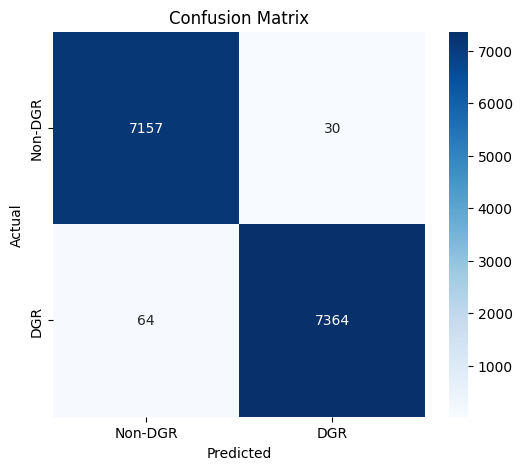

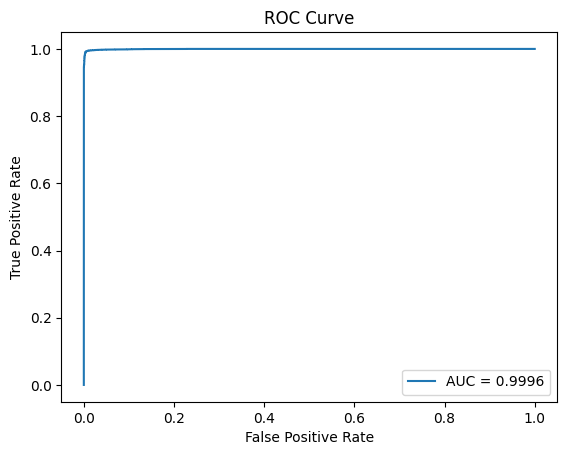

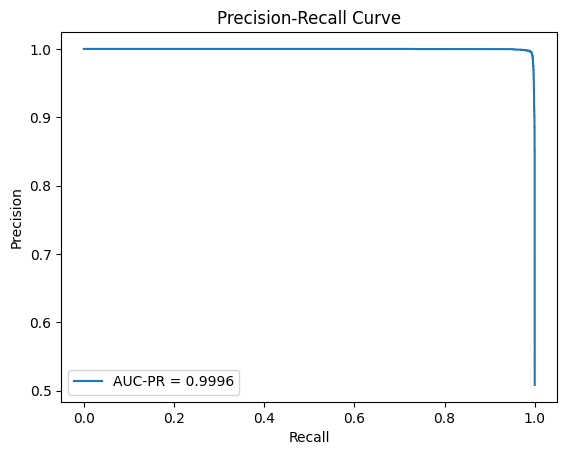

In [1]:
### MODEL_VERSION_2.2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score, recall_score, 
    f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
)

# 1. 读取数据
dgr_train = np.load("vr_tr_embeddings.npy")  # (37073, 1024)
neg_train = np.load("neg_train_embeddings.npy")  # (36000, 1024)
rt_embeddings = np.load("rt_embeddings.npy")  # (33342, 1024)

# 处理 RT 数据：取均值作为全局 RT 特征
rt_global = np.mean(rt_embeddings, axis=0)  # (1024,)

# 2. 数据集准备
X = np.vstack([dgr_train, neg_train])  # (73073, 1024)
y = np.concatenate([np.ones(len(dgr_train)), np.zeros(len(neg_train))])  # (73073,)

# 复制 RT 特征，使其匹配样本数
RT = np.tile(rt_global, (len(X), 1))  # (73073, 1024)

# 转换为 PyTorch 张量
X_tensor = torch.tensor(X, dtype=torch.float32)
RT_tensor = torch.tensor(RT, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 3. 划分训练集和测试集（80% 训练，20% 测试）
dataset = TensorDataset(X_tensor, RT_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 4. 数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 5. CNN + BiLSTM + Attention 模型
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim=1024, rt_dim=1024, hidden_dim=128, lstm_layers=1, num_classes=2):
        super(CNN_BiLSTM_Attention, self).__init__()

        # CNN 部分（卷积 + 池化）
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # BiLSTM 部分
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_dim, num_layers=lstm_layers, 
                            batch_first=True, bidirectional=True)

        # RT 特征转换
        self.rt_fc = nn.Linear(rt_dim, hidden_dim * 2)

        # Attention 机制
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # 全连接层
        self.fc1 = nn.Linear(hidden_dim * 4, 64)  
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x, rt):
        x = x.unsqueeze(1)  

        # CNN
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  

        x = x.permute(0, 2, 1)  

        # BiLSTM
        lstm_out, _ = self.lstm(x)  

        # Attention
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  
        attn_output = torch.sum(attn_weights * lstm_out, dim=1)  

        # 处理 RT 特征
        rt_out = F.relu(self.rt_fc(rt))  

        # 结合 Attention 输出和 RT
        combined = torch.cat((attn_output, rt_out), dim=1)  

        # 全连接层
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)

        return x


# 6. 训练与评估
def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, RT_batch, y_batch in train_loader:
            X_batch, RT_batch, y_batch = X_batch.to(device), RT_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch, RT_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Train Acc: {correct/total:.4f}")

    # 评估
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for X_batch, RT_batch, y_batch in test_loader:
            X_batch, RT_batch, y_batch = X_batch.to(device), RT_batch.to(device), y_batch.to(device)
            outputs = model(X_batch, RT_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]  
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    torch.save(model.state_dict(), "dgr_classifier.pth")
    print("Model saved successfully!")
    
    # 计算指标
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}, AUC-PR: {pr_auc:.4f}")

    # 绘制混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-DGR", "DGR"], yticklabels=["Non-DGR", "DGR"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # 绘制 ROC 曲线
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # 绘制 Precision-Recall 曲线
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(recall, precision, label=f"AUC-PR = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()


# 7. 运行
model = CNN_BiLSTM_Attention()
train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=1e-3)



In [1]:
### MODEL_VERSION_1.1

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F

# 1. 读取数据
dgr_train = np.load("dgr_train.npy")  # (37073, 1024)
neg_train = np.load("neg_train.npy")  # (36000, 1024)
rt_embeddings = np.load("rt_embeddings.npy")  # (33342, 1024)

# 处理 RT 数据：取均值作为全局 RT 特征
rt_global = np.mean(rt_embeddings, axis=0)  # (1024,)

# 2. 数据集准备
X = np.vstack([dgr_train, neg_train])  # (73073, 1024)
y = np.concatenate([np.ones(len(dgr_train)), np.zeros(len(neg_train))])  # (73073,)

# 复制 RT 特征，使其匹配样本数
RT = np.tile(rt_global, (len(X), 1))  # (73073, 1024)

# 转换为 PyTorch 张量
X_tensor = torch.tensor(X, dtype=torch.float32)
RT_tensor = torch.tensor(RT, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 3. 划分训练集和测试集（80% 训练，20% 测试）
dataset = TensorDataset(X_tensor, RT_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 4. 数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 5. CNN + BiLSTM + Attention 模型（增加 RT 额外输入）
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim=1024, rt_dim=1024, hidden_dim=128, lstm_layers=1, num_classes=2):
        super(CNN_BiLSTM_Attention, self).__init__()

        # CNN 部分（卷积 + 池化）
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # BiLSTM 部分
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_dim, num_layers=lstm_layers, 
                            batch_first=True, bidirectional=True)

        # RT 特征转换
        self.rt_fc = nn.Linear(rt_dim, hidden_dim * 2)  # 将 RT 维度转换为 LSTM 维度

        # Attention 机制
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # 全连接层
        self.fc1 = nn.Linear(hidden_dim * 4, 64)  # 这里使用 hidden_dim * 4 以包含 RT 信息
        self.fc2 = nn.Linear(64, num_classes)  # 二分类（DGR / Non-DGR）

    def forward(self, x, rt):
        x = x.unsqueeze(1)  # (batch, 1, 1024)

        # CNN 提取局部特征
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch, 128, 256)

        x = x.permute(0, 2, 1)  # 调整为 LSTM 输入形状 (batch, seq_len, features)

        # BiLSTM 处理序列信息
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim*2)

        # Attention 计算权重
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch, seq_len, 1)
        attn_output = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, hidden_dim*2)

        # 处理 RT 特征
        rt_out = F.relu(self.rt_fc(rt))  # (batch, hidden_dim*2)

        # 结合 Attention 输出和 RT
        combined = torch.cat((attn_output, rt_out), dim=1)  # (batch, hidden_dim*4)

        # 全连接层分类
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)

        return x


# 6. 训练与评估
def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 损失函数 & 优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 训练循环
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for X_batch, RT_batch, y_batch in train_loader:
            X_batch, RT_batch, y_batch = X_batch.to(device), RT_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch, RT_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}")

    # 评估
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, RT_batch, y_batch in test_loader:
            X_batch, RT_batch, y_batch = X_batch.to(device), RT_batch.to(device), y_batch.to(device)
            outputs = model(X_batch, RT_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    torch.save(model.state_dict(), "dgr_classifier.pth")
    print("Model saved successfully!")


# 7. 运行训练
model = CNN_BiLSTM_Attention()
train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=1e-3)


Epoch [1/10], Loss: 445.9548, Train Acc: 0.8779
Epoch [2/10], Loss: 141.2273, Train Acc: 0.9751
Epoch [3/10], Loss: 119.2393, Train Acc: 0.9785
Epoch [4/10], Loss: 106.0019, Train Acc: 0.9803
Epoch [5/10], Loss: 94.7508, Train Acc: 0.9824
Epoch [6/10], Loss: 86.2911, Train Acc: 0.9843
Epoch [7/10], Loss: 80.9216, Train Acc: 0.9850
Epoch [8/10], Loss: 74.7000, Train Acc: 0.9861
Epoch [9/10], Loss: 71.2480, Train Acc: 0.9869
Epoch [10/10], Loss: 64.3226, Train Acc: 0.9878
Test Accuracy: 0.9897
Model saved successfully!


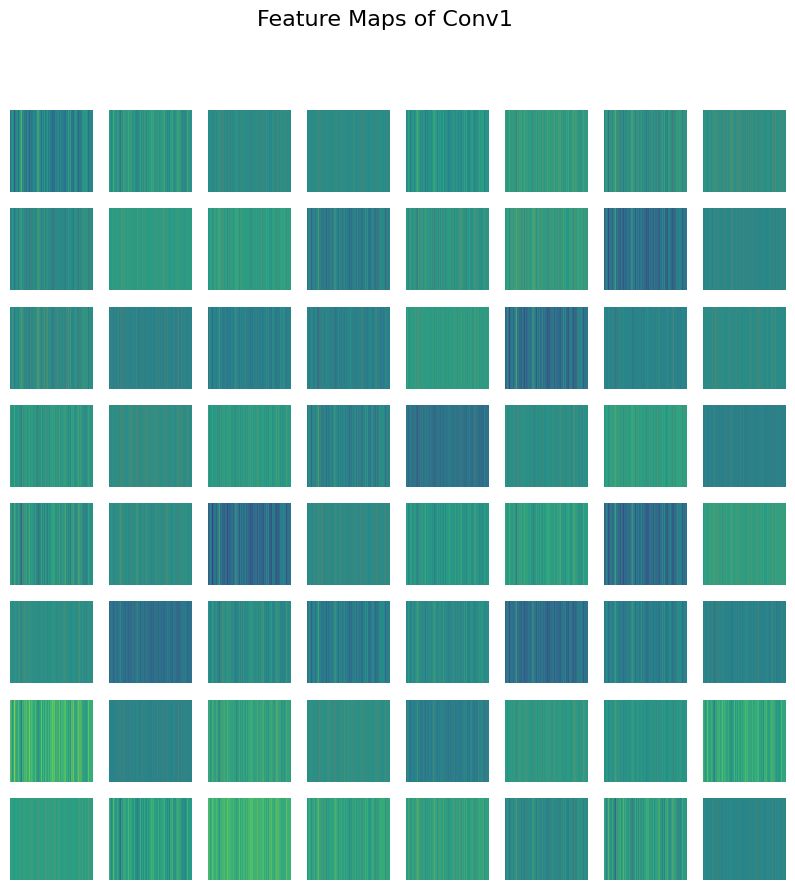

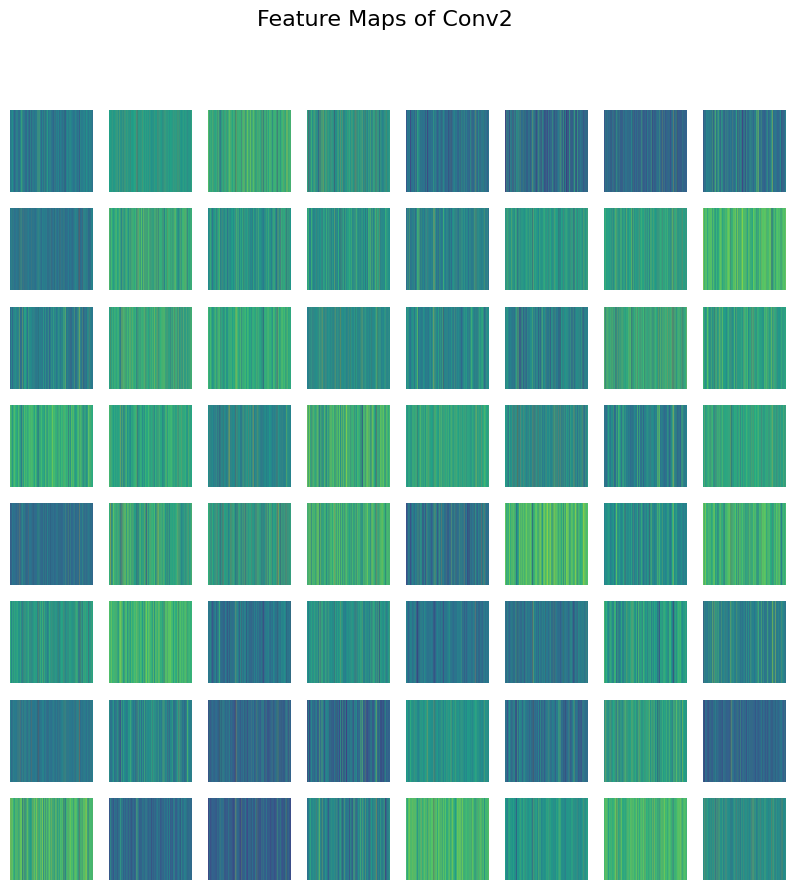

In [18]:
import matplotlib.pyplot as plt
model = CNN_BiLSTM_Attention()

# 存储特征图
feature_maps = {}

# Hook 函数用于捕获特征图
def hook_fn(module, input, output):
    feature_maps[module] = output.detach()

# 注册 Hook
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)

# 生成随机输入数据 (batch_size=1, channels=1, seq_len=1024)
input_data = torch.randn(1, 1024)

# 前向传播
with torch.no_grad():
    model(input_data)

# 可视化特征图
def plot_feature_maps(feature_map, layer_name):
    num_channels = feature_map.shape[1]  # 通道数
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))  # 8x8 画布
    fig.suptitle(f'Feature Maps of {layer_name}', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < num_channels:
            ax.imshow(feature_map[0, i, :].reshape(1, -1), cmap='viridis', aspect='auto')
        ax.axis('off')
    
    plt.show()

# 绘制 `conv1` 和 `conv2` 的特征图
plot_feature_maps(feature_maps[model.conv1], "Conv1")
plot_feature_maps(feature_maps[model.conv2], "Conv2")

In [2]:
print(model)

CNN_BiLSTM_Attention(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN_BiLSTM_Attention().to(device)

checkpoint = torch.load("dgr_classifier.pth", map_location=device)  # 载入模型参数
model.load_state_dict(checkpoint)

model.eval()  # 设置为推理模式
print("✅ 预训练模型 `dgr_classifier.pth` 加载成功！")

✅ 预训练模型 `dgr_classifier.pth` 加载成功！


C:\Users\13482\AppData\Local\Temp\ipykernel_17068\4014585810.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("dgr_classifier.pth", map_location=d

In [3]:
from torchviz import make_dot
import torch

# 生成一个随机输入 (batch_size=1, channels=1, sequence_length=1024)
dummy_input = torch.randn(1, 1024)  # (batch_size=1, sequence_length=1024) → (1, 1, 1024)
output = model(dummy_input)

# 生成计算图
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("cnn_bilstm_attention", format="png")  # 生成 PNG 图像


'cnn_bilstm_attention.png'